# Sheet 3: Bootstrapping and MCMC

In [1]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
from resample.bootstrap import variance

# create instance of pseudo-random number generator with fixed seed = 1
rng = np.random.default_rng(seed=1)

---

## Task 1: Bootstrapping method

We apply the bootstrap method to two simple estimators.

### 1.1

Compute the uncertainties of the arithmetic mean and the median on the sample $v =$ [20, 1, 5, 1, 3, 2, 2, 5, 4, 1, 10, 2, 3] with the bootstrap method.

A simple algorithm to generate a bootstrap sample for an estimator is as follows:
  * Generate $m$ bootstrap samples of the same size by drawing random numbers from the original sample with replacement.  
    If the original sample has size $n$, a simple technique to obtain one bootstrap sample is this algorithm:
    * Repeat $n$ times:
      - Generate a random integer index $k < n$ from a uniform distribution.
      - Add `v[k]` to the current bootstrap sample, where `v` is the array that holds the original sample.
    * Compute the estimator on the bootstrap sample and store the result in an array.

You thus get a sample of bootstrapped estimator values of size $m$. You can compute the unbiased standard deviation to  
estimate the uncertainty of the estimator or compute quantiles which correspond to confidence intervals.

Plot a histogram of the bootstrapped means and medians. Calculate the unbiased standard deviation for each sample.  
For the arithmetic mean, the analytical uncertainty estimate is well-known, it is the unbiased standard deviation computed   
from the original sample divided by $\sqrt{n}$. Compare this to the bootstrapped estimate.

_Hint_: The unbiased standard deviation is obtained in Numpy with `np.std(my_array, ddof=1)`.

---

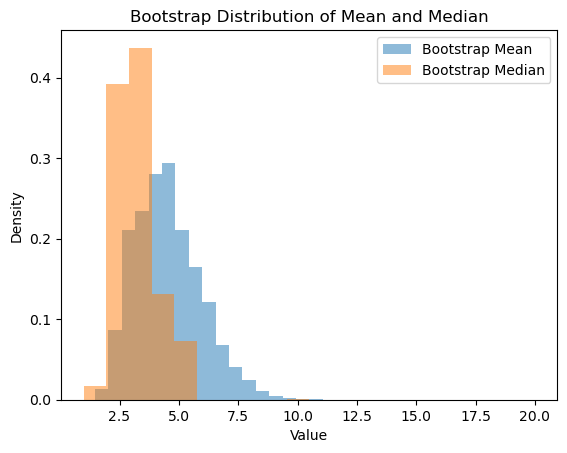

In [33]:
sample = [20, 1, 5, 1, 3, 2, 2, 5, 4, 1, 10, 2, 3]

bootstrap_samples = [np.random.choice(sample, size=len(sample)) for _ in range(100_000)]


def compute_estimator(sample: np.ndarray) -> float:
    values, counts = np.unique(sample, return_counts=True)
    # print(np.sum(counts)/len(sample))
    return np.sum(values*counts) / len(sample)


mean_bs = [compute_estimator(bs) for bs in bootstrap_samples]
median_bs = [np.median(bs) for bs in bootstrap_samples]
unbiased_std = [np.std(bs, ddof=1) for bs in bootstrap_samples]
arithmetic_mean = [np.mean(bs) for bs in bootstrap_samples]


plt.hist(mean_bs, bins=20, density=True, label='Bootstrap Mean', alpha=0.5)
plt.hist(median_bs, bins=20, density=True, label='Bootstrap Median', alpha=.5)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Bootstrap Distribution of Mean and Median');

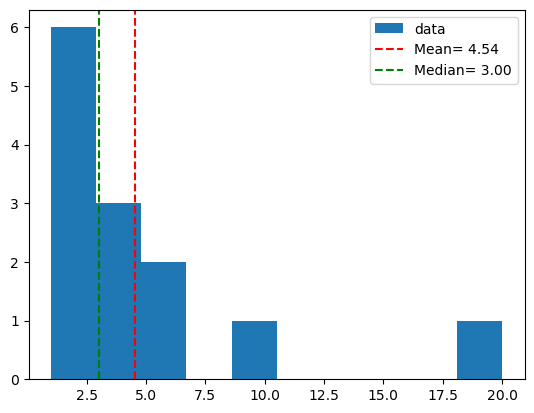

In [37]:
data = [20, 1, 5, 1, 3, 2, 2, 5, 4, 1, 10, 2, 3]
n = len(data)

plt.hist(data, label="data")
plt.axvline(np.mean(data), color='red', linestyle='--', label='Mean= {:.2f}'.format(np.mean(data)))
plt.axvline(np.median(data), color='green', linestyle='--', label='Median= {:.2f}'.format(np.median(data)))
plt.legend();

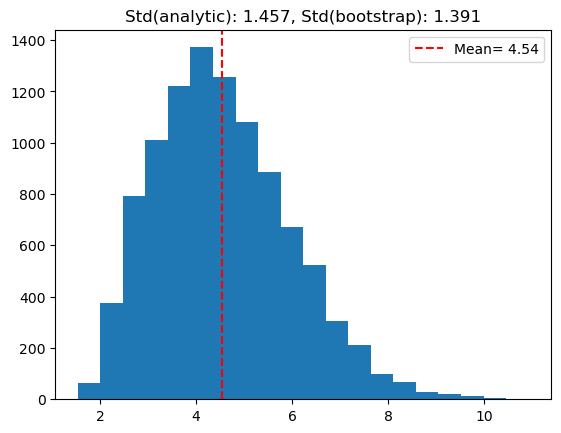

In [42]:
m_bootstrap = 10_000

bootstrap_means = []
bootstrap_medians = []

for _ in range(m_bootstrap):
    bootstrap_sample = []

    for _ in range(n):
        k = rng.integers(0,n)
        bootstrap_sample.append(data[k])
    
    bootstrap_means.append(np.mean(bootstrap_sample))
    bootstrap_medians.append(np.median(bootstrap_sample))

plt.figure()
plt.hist(bootstrap_means, bins=20)
plt.axvline(np.mean(data), color='red', linestyle='--', label='Mean= {:.2f}'.format(np.mean(data)))
plt.title(f"Std(analytic): {np.std(data, ddof=1)/n**.5:.3f}, Std(bootstrap): {np.std(bootstrap_means, ddof=1):.3f}")
plt.legend();

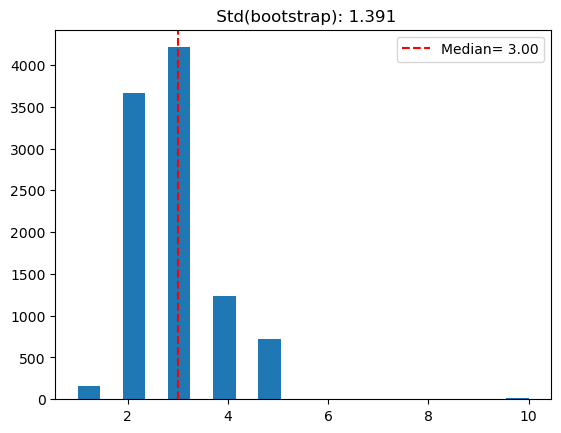

In [46]:
plt.figure()
plt.hist(bootstrap_medians, bins=20)
plt.axvline(np.median(data), color='red', linestyle='--', label='Median= {:.2f}'.format(np.median(data)))
plt.title(f" Std(bootstrap): {np.std(bootstrap_means, ddof=1):.3f}")
plt.legend();

---

### 1.2

Check your result by using the function `variance` from `resample.bootstrap`. You need to take the square-root of the variance to get the standard deviation. Use the keyword `size` to increase the number of bootstrap samples to 10000.

---

In [47]:
variance_mean = variance(np.mean, sample, size=100_000)**.5
variance_median = variance(np.median, sample, size=100_000)**.5

print(f"Variance of the mean: {variance_mean:.3f}")
print(f"Variance of the median: {variance_median:.3f}")

Variance of the mean: 1.397
Variance of the median: 0.950


In [48]:
variance_mean = variance(np.mean, sample, method="extended", size=100_000)**.5
variance_median = variance(np.median, sample, method="extended", size=100_000)**.5

print(f"Variance of the mean: {variance_mean:.3f}")
print(f"Variance of the median: {variance_median:.3f}")

Variance of the mean: 1.463
Variance of the median: nan


/Users/joeykoch/mambaforge/envs/SMD2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joeykoch/mambaforge/envs/SMD2/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---

## Task 2: MCMC

Two random numbers (x, y) follow a two-dimensional density proportional to $f(x, y)$

$$
f(x, y) \propto \exp\left(-((x-2)x + y^2)/10\right)\cdot\sin^2(x\cdot y + x) \,.
$$

Determine the distribution $\rho(r)$ with $r = (x^2 + y^2)^{1/2}$ with Marcov-Chain Monte-Carlo.

### 2.1

Generate samples from $f(x, y)$ with the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). Use a standard normal distribution for the proposal step.

* Draw random numbers from $f(x, y)$ with Metropolis-Hastings. Use the starting value (1, 1).
* Compute $r$ from $(x, y)$.
* Draw a 2D histogram of $(x, y)$ and a 1D histogram of $r$.

---

In [111]:
start = (1, 1)

def density(x, y):
    return np.exp(-((x-2)*x+y**2)/10) * np.sin(x*y+x)


def rho(r):
    x, y = r
    return (x**2 + y**2)**0.5


def metropolis_hastings(n_samples, start):
    samples = [start]
    current = start

    for _ in range(n_samples):
        proposal = (current[0] + rng.standard_normal(), current[1] + rng.standard_normal())
        acceptance_ratio = density(*proposal) / density(*current)

        if rng.random() < acceptance_ratio or acceptance_ratio >= 1:
            current = proposal

        samples.append(current)

    return np.array(samples)

n_samples = 100_000
samples = metropolis_hastings(n_samples, start)

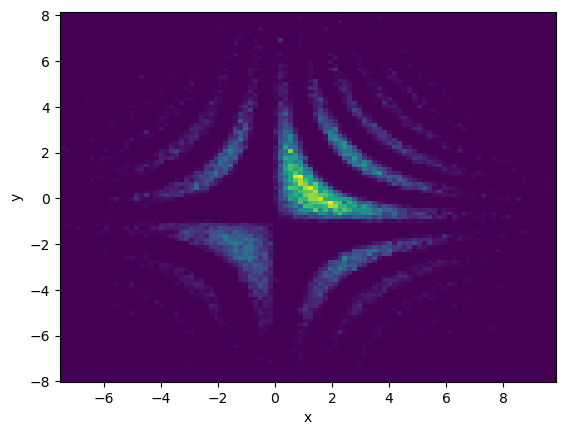

In [112]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=100)
plt.xlabel('x')
plt.ylabel('y');

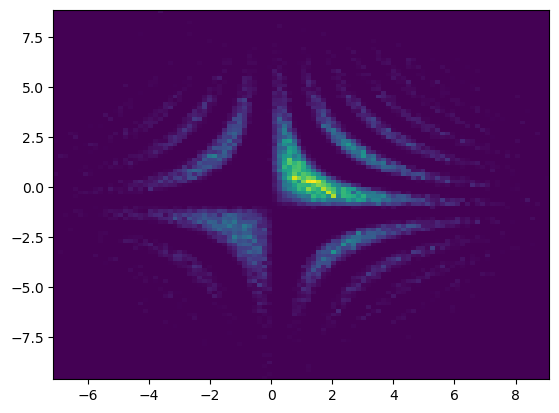

In [126]:
def density(x, y):
    return np.exp(-((x-2)*x+y**2)/10) * np.sin(x*y+x)


result = []
pt0 = (1, 1)
d0 = density(*pt0)

for _ in range(100_000):
    pt1 = rng.normal(pt0)
    d1 = density(*pt1)
    
    alpha = d1 / d0
    if rng.uniform() <= alpha or alpha >= 1:
        pt0 = pt1
        d0 = d1
    
    result.append(pt0)


x, y = np.transpose(result)
plt.hist2d(x, y, bins=100);

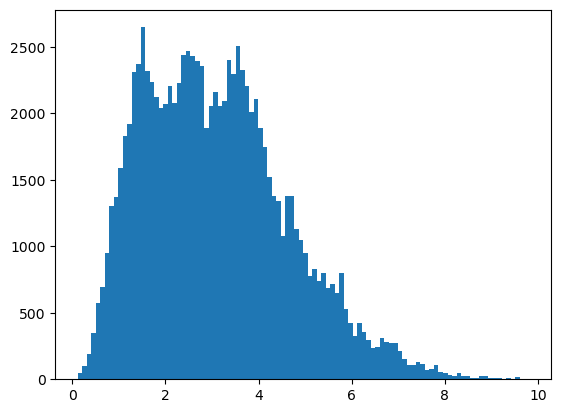

In [127]:
r = rho((x, y))
plt.hist(r, bins=100);

---

### 2.2

Our basic algorithm lacks many improvements that are present in professional libraries. Most importantly, it is best to follow several Markov chains in parallel, which allows one to check for convergence.

To see this, use the `EnsembleSampler` from the `emcee` package to perform the same task as in [2.1](#2.1). Use 32 walkers and use starting points drawn from a standard normal distribution.

---

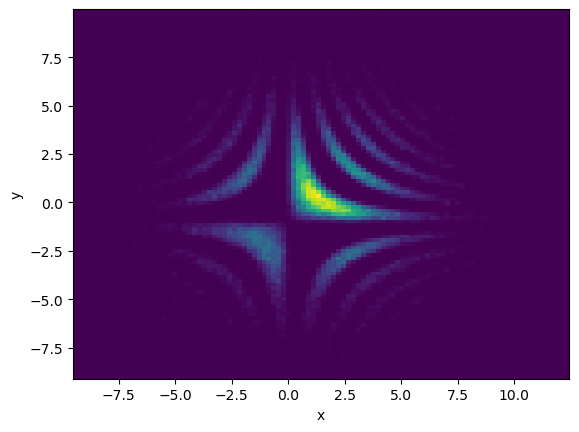

In [134]:
def log_density(par):
    d = density(*par)
    if d <= 0 or np.isnan(d):
        return -np.inf
    return np.log(d)


nwalkers = 32
ndim = 2
p0 = rng.normal(size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_density)
sampler.run_mcmc(p0, 10_000);

samples = sampler.get_chain(flat=True)
plt.hist2d(samples[:, 0], samples[:, 1], bins=100)
plt.xlabel('x')
plt.ylabel('y');

---

## Task 3

We will now use MCMC to solve the following inference problem using Bayes' theorem.

* An experiment observes $n$ events from a Poisson distribution.
* The true rate μ for events to occur is a function of two parameters $a$ and $b$, $μ = a^b$.
  * The parameter $a$ must be positive.
  * The parameter $b$ is known to be close to $b = 1$, a uniform distribution in the range $0.9 < b < 1.1$ is assumed for it.
* The detection probability for an event is $ε$. The observed rate $\mu'$ then is the true rate $\mu$ times the detection probability $ε$.
  * It is known from external measurements that $ε$ is approximately Gaussian distributed around 0.75 with a standard deviation of 0.05.
  * The Gaussian is truncated to satisfy $0 < \varepsilon \le 1$.

In a particular run of the experiment, the experimenters find $n$ events. 

### 3.1
Use Bayes' theorem to compute the posterior distribution of $a$ for the outcomes $n = 1$ and $n = 10$.

To do this, write a function which is proportional to the posterior probability distribution of the parameters using Bayes Theorem and then sample from it using the `emcee` package. As starting points for the walkers, use random points for which the prior density is not zero. Plot a histogram of the $a$ samples.

_Hint:_ It is often more precise and more efficient to program a function which computes the logarithm of the posterior density instead of calculating the normal density and then taking the logarithm. Where the prior density is zero, return `-numpy.inf` in the log-density function.

---